In [1]:
import os
import numpy as np
import math
os.environ["NUMBA_ENABLE_CUDASIM"] = "1"
from numba import jit, njit, vectorize, cuda
from numba import vectorize, int64, float64

## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [2]:
@vectorize([float64(float64)], target='parallel', fastmath=True) 
def vec_log(x):
    c =  np.log(x)
    return c

@vectorize([float64(float64)], target='parallel', fastmath=True) 
def vec_exp(x):
    c =  np.exp(x)
    return c

A = np.array([2, 5, 10, 3, 8])

logA = vec_log(A)
expA = vec_exp(A)

print(logA)
print(expA)

[0.69314718 1.60943791 2.30258509 1.09861229 2.07944154]
[7.38905610e+00 1.48413159e+02 2.20264658e+04 2.00855369e+01
 2.98095799e+03]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

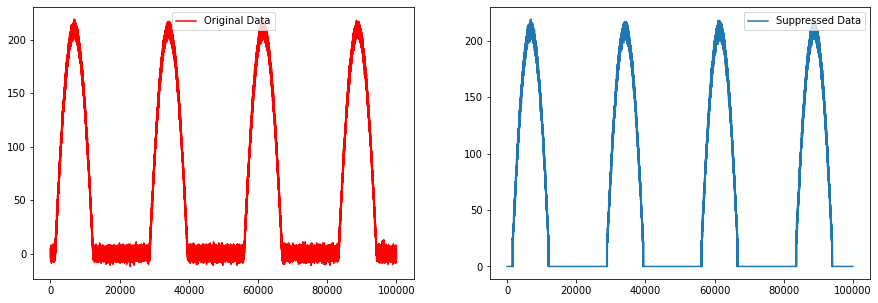

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

threshold = 20
n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

data_suppressed = np.copy(data)


@cuda.jit
def zero_suppression(array, array2, magnitude):
    pos = cuda.grid(1)
    
    if pos < array.size:
        if array[pos] < magnitude: array2[pos] = 0


# Set the number of threads in a block
threadsperblock = 32 

# Calculate the number of thread blocks in the grid
blockspergrid = (data.size + (threadsperblock - 1)) // threadsperblock

# Now start the kernel
zero_suppression[blockspergrid, threadsperblock](data, data_suppressed ,threshold)

fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(data, label="Original Data", color='r')
ax[1].plot(data_suppressed, label="Suppressed Data")

ax[0].legend()
ax[1].legend()
plt.show()

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [4]:
X = np.random.rand(3,3)
Y = np.random.rand(3,3)
a=0.3
c=0.1

# CUDA kernel
@cuda.jit
def sigmoid_kernel(array_out, x, y, a, c):
    row, col = cuda.grid(2)
    
    if row < array_out.shape[0] and col < array_out.shape[1]:
        array_out[row][col] = np.tanh(a*np.dot(x[row],y[col])+c)

array_out = np.zeros((len(X), len(Y)))

# Configure the blocks
threadsperblock = (64, 16) #ThreadsPerBlock must be a divisor of the data dimension: 1024/ 64 / 16 = 1
blockspergrid_x = int(math.ceil(array_out.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(array_out.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

sigmoid_kernel[blockspergrid, threadsperblock](array_out, X, Y, a, c)
print(array_out)

[[0.53757121 0.25065221 0.53279267]
 [0.37652976 0.21318845 0.44340999]
 [0.43205648 0.26658363 0.53776678]]


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [5]:
matrix = np.random.rand(256,256,256) * np.pi

@cuda.jit
def cos_3d_matrix(io_array):
    row, col, z = cuda.grid(3)
        
    if row < io_array.shape[0] and col < io_array.shape[1] and z < io_array.shape[2]:
        io_array[row][col][z] = np.cos(io_array[row][col][z])
        
        

cos_3d_matrix[blockspergrid, threadsperblock](matrix)

print(matrix) 


[[[ 0.95121983  1.46033702  2.43563555 ...  2.33140348  1.0659331
    1.07708057]
  [ 0.77633344  2.47548933  0.78216234 ...  0.85761345  0.97420357
    1.54968812]
  [-0.15095049  1.51478133  1.95277673 ...  2.33963191  0.22561326
    2.50175559]
  ...
  [ 2.48144711  1.86249926  2.43315228 ...  2.88970683  0.74006
    0.63268492]
  [ 2.83040327  1.45214714  2.4275084  ...  2.22595834  1.01832371
    1.46620892]
  [ 0.53393487  3.03213706  1.92958247 ...  1.93042996  1.24004918
    0.9148986 ]]

 [[ 0.30691962  0.14264     1.51668196 ...  0.52320806  2.35379478
    1.26525604]
  [ 0.47034289  2.80632401  2.56719382 ...  0.83781795  0.52272992
    1.77772049]
  [-0.5006503   1.3516903   1.18237794 ...  0.88094738  1.30081655
    2.71945338]
  ...
  [ 1.55713116  1.37899834  0.96458447 ...  0.87528229  2.49530261
    0.09344303]
  [ 1.2123809   2.91623377  2.46250916 ...  2.94752325  1.9231403
    2.69238348]
  [ 2.51806345  2.71628319  1.85836881 ...  2.31208885  3.10192202
    2.62886

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [6]:
from __future__ import division
from numba import cuda
import numpy
import math


# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays

A = np.random.randint(50, size=(24, 12))
B = np.random.randint(50, size=(12, 22))
C = np.zeros((24,22))

# Configure the blocks
threadsperblock = (64, 16)
blockspergrid_x = int(math.ceil(A.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(B.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

matmul[blockspergrid, threadsperblock](A, B, C)


print(C)

[[ 9018.  6025.  7046.  3490.  7768.  8446.  6610.  5535.  8419.  6062.
   8179.  8856.  8087.  7168.  7733. 10631.  5598.  7115.  3742.  5296.
   7337.  5737.]
 [ 6462.  4696.  5379.  5445.  6177.  8682.  6523.  4590.  9709.  4724.
   8453.  7857.  6283.  6252.  6896.  8065.  8153.  5452.  3030.  4142.
   6710.  6109.]
 [ 6693.  5168.  5374.  3070.  6623.  6878.  5257.  4535.  6405.  4551.
   6682.  7727.  7117.  6433.  6537.  8392.  4652.  6407.  3083.  4224.
   6154.  5290.]
 [ 7162.  4495.  6327.  3926.  6701.  7599.  5987.  5260.  8681.  5448.
   8092.  9767.  8275.  7085.  6939.  9574.  7052.  8132.  3852.  5833.
   4957.  3861.]
 [ 9858.  6519.  6891.  5330.  9999. 10268.  9955.  7473. 12006.  7867.
  10950.  9845.  9641.  8826.  7855. 11100.  8842.  8397.  4270.  6720.
   8627.  6153.]
 [ 8456.  6015.  5138.  4157.  8968.  7804.  8446.  6449. 10398.  5254.
   9105.  8147.  7419.  7710.  6526. 10013.  7131.  7334.  2769.  6581.
   7909.  5991.]
 [ 8203.  6341.  6025.  3235.  733